import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

#sys.path.append('/home/skong2/project/dpff4ldl')
#from utils.metrics import *
#from utils.metrics import *
#from utils.flow_functions import *
#from models.pem import *
#from models.PEM_compact import *
#from fetchData.datasetCOMBINED import *
#from trainingProtocol.trainval_COM2s_intFlow_LazyPrior_bidirection import *
#from trainingProtocol.trainval_COM2s_intFlow_sLazyPrior_bidirectionAllLayers import *
#from losses import *
#from losses_suppl import *

from utils.flow_functions import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

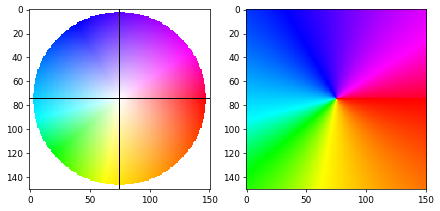

In [2]:
objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())

figWinNumHeight, figWinNumWidth = 1, 2
plt.figure(figsize=(figWinNumWidth*4,figWinNumHeight*4), dpi=64, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(objDemoShowFlow.FlowColorChart)

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(objDemoShowFlow.FlowColorChartNoAxes)

#misc.imsave(os.path.join(save_dir, 'colorchar.png'.format(idx)), objDemoShowFlow.FlowColorChart*255, format='png')

In [3]:
path_to_image = '/home/skong2/restore/dataset/pollenProject_dataset_part1'
path_to_annotCombo = '/home/skong2/restore/dataset/pollenProject_dataset_annotationCombo'

with open('dbinfo.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)
    
dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(dict_keys(['train_det_list', 'test_det_list', 'train_det_className', 'test_det_className', 'train_det_classID', 'test_det_classID']),
 4997,
 1218)

In [38]:
class PollenDet(Dataset):
    def __init__(self, path_to_image='/home/skong2/restore/dataset/pollenProject_dataset_part1',
                 path_to_annot='/home/skong2/restore/dataset/pollenProject_dataset_annotationCombo',
                 dbinfo=None,
                 size=[512, 512], 
                 set_name='train'):
        
        self.path_to_image = path_to_image
        self.path_to_annot = path_to_annot
        self.transform = transform
        self.dbinfo = dbinfo
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name        
        self.size = size
        
        self.sampleList = self.dbinfo[set_name+'_det_list']
        self.clsNameList = self.dbinfo[set_name+'_det_className']
        self.clsIDList = self.dbinfo[set_name+'_det_classID']
        
        self.TFNormalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        self.current_set_len = len(self.sampleList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        self.TFresize = transforms.Resize((self.size[0],self.size[1]))
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):        
        curClassName = self.dbinfo['train_det_className'][idx]
        curImageName = path.join(self.path_to_image, self.dbinfo['train_det_list'][idx]+'.png')
        curPickleName = path.join(self.path_to_annot, self.dbinfo['train_det_list'][idx]+'.pkl')

        with open(curPickleName, 'rb') as handle:
            annot = pickle.load(handle)
        
        image = PIL.Image.open(curImageName)
        
        if self.set_name=='train' and np.random.random(1)>0.5:
            image = image.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            for i in range(annot['coord_peaks'].shape[0]):
                y, x = annot['coord_peaks'][i] # annot['size'][0]:y, annot['size'][1]:x
                #ynew = y
                #xnew = annot['size'][1]-x
                annot['coord_peaks'][i][1] = annot['size'][1]-x
        
        image = np.array(image)
        times = np.random.randint(1)
        if times!=0:
            if times==1:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[1]-x
                    annot['coord_peaks'][i][1] = y
                    annot['size'] = (annot['size'][1], annot['size'][0])                    
            elif times==2:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[0]-y
                    annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[1]-x
            elif times==3:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = x
                    annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[0]-y
                    annot['size'] = (annot['size'][1], annot['size'][0])
            #for _ in range(times):
            image = np.rot90(image, times).copy()
        
        label = np.zeros((annot['size'][0], annot['size'][1]), dtype=np.float32)
        mask_distanceTransform = label*0.
        mask_peaks = label*0.
        mask_radius = label*0.
        mask_voteX = label*0.
        mask_voteY = label*0.
        mask_overlap = label*0.
        
        for i in range(annot['coord_peaks'].shape[0]):
            y, x = annot['coord_peaks'][i]
            r = annot['mask_radius'][i]
            #mask_peaks[y-10:y+10, x-10:x+10] = 1
            #mask_radius[y-10:y+10, x-10:x+10] = r
            mask_peaks[y, x] = 1
            mask_radius[y, x] = r

            mask_x, mask_y = np.asarray(range(label.shape[1])).astype(np.float), np.asarray(range(label.shape[0])).astype(np.float)
            mask_x, mask_y = np.meshgrid(mask_x, mask_y)
            mask_x = float(x) - mask_x
            mask_y = float(y) - mask_y

            tmpDistTransform = np.sqrt(mask_x*mask_x + mask_y*mask_y)
            tmpmask_vote = tmpDistTransform <= r
            label[tmpmask_vote] = 1.0
            mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
            mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
            mask_distanceTransform[tmpmask_vote] = r-tmpDistTransform[tmpmask_vote]
            mask_overlap += tmpmask_vote.astype(np.float)
            
        mask_overlap = mask_overlap>1
        mask_overlap = mask_overlap.astype(np.float32)
        # mask_overlap
        mask_voteX = mask_voteX.astype(np.float32)/100.0
        mask_voteY = mask_voteY.astype(np.float32)/100.0
        mask_distanceTransform = mask_distanceTransform.astype(np.float32)/100.0
        mask_peaks = mask_peaks.astype(np.float32)
        mask_radius = mask_radius.astype(np.float32)/100.0
        
        image = self.TF2tensor(image)
        label = torch.from_numpy(label).unsqueeze(0) # self.TF2tensor(label)
        mask_overlap = torch.from_numpy(mask_overlap).unsqueeze(0) # self.TF2tensor(mask_overlap)
        mask_voteX = torch.from_numpy(mask_voteX).unsqueeze(0) # self.TF2tensor(mask_voteX)
        mask_voteY = torch.from_numpy(mask_voteY).unsqueeze(0) # self.TF2tensor(mask_voteY)
        mask_distanceTransform = torch.from_numpy(mask_distanceTransform).unsqueeze(0) # self.TF2tensor(mask_distanceTransform)
        mask_peaks = torch.from_numpy(mask_peaks).unsqueeze(0) # self.TF2tensor(mask_peaks)
        mask_radius = torch.from_numpy(mask_radius).unsqueeze(0) # self.TF2tensor(mask_radius)
        
        #image = image.unsqueeze(0)
        #label = label.unsqueeze(0)        
        #image = F.interpolate(image, size=(self.size[0],self.size[1]), mode='bilinear', align_corners=True)
        #label = F.interpolate(label, size=(self.size[0], self.size[1]), mode='nearest')
        #image = image.squeeze(0)
        image = self.TFNormalize(image)
        #label = label.squeeze(0)
        return image, label, mask_distanceTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius

In [39]:
batch_size = 10

det_datasets = {set_name: PollenDet(path_to_image=path_to_image,
                                    path_to_annot=path_to_annotCombo,
                                    dbinfo=dbinfo,
                                    size=[1000, 1000], 
                                    set_name=set_name)
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(det_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']}

print(len(det_datasets['train']), len(det_datasets['test']))

4997 1218


In [40]:
data_sampler = iter(dataloaders['train'])

In [41]:
data = next(data_sampler)

In [42]:
image, label, mask_distanceTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius = data
#image.shape, label.shape, mask_distanceTransform.shape, mask_overlap.shape, mask_voteX.shape, mask_voteY.shape, mask_peaks.shape, mask_radius.shape

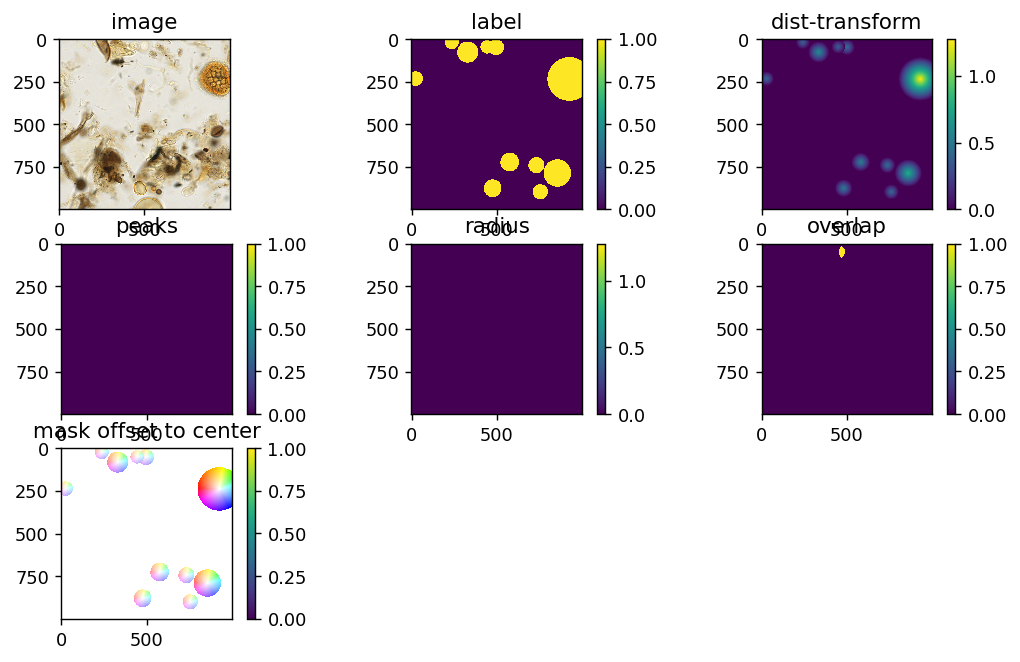

In [46]:
idx = 3

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 3
plt.figure(figsize=(10, 6), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx].squeeze().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('image')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = label[idx].squeeze().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('label')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_distanceTransform[idx].squeeze().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('dist-transform')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_peaks[idx].squeeze().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('peaks')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_radius[idx].squeeze().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('radius')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_overlap[idx].squeeze().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('overlap')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpV = mask_voteX[idx].squeeze().detach().numpy()
tmpU = mask_voteY[idx].squeeze().detach().numpy()
flowVisShow = objDemoShowFlow.computeColor(
    tmpV/np.abs(tmpV).max(), 
    tmpU/np.abs(tmpU).max())/255.    
plt.imshow(flowVisShow)
#plt.axis('off')
plt.title('mask offset to center')
plt.colorbar()




Leaving Blank
-----